# Time Series Analysis on Gold and Silver Price
                                  --Using ARIMA Model to Predict Gold and Silver Price

In this article, I will use ARIMA model to predict gold and silver price. The historical prices of gold and silver is from the links below:
      https://www.investing.com/commodities/gold-historical-data
      https://www.investing.com/commodities/silver-historical-data
 

In [2]:
import numpy as np
import pandas as pd
import csv
import pandasql

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import pyplot

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

import warnings
import itertools

In [989]:
#download the data from my computer.
 
 
df_gold = pd.read_csv( r"C:...\Gold Futures Historical Data.csv",sep= '\t')
df_silver = pd.read_csv( r"C:...\Silver Futures Historical Data.csv",sep= '\t')
df_gold.head()
df_silver.head()
   

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-08-01,16.35,16.27,16.40,15.94,-,0.00
1,2019-07-31,16.41,16.59,16.60,16.22,107.09K,-0.01
2,2019-07-30,16.56,16.50,16.64,16.43,57.74K,0.01
3,2019-07-29,16.44,16.42,16.50,16.36,62.06K,0.00
4,2019-07-28,16.40,16.43,16.45,16.40,-,0.00


Next, I am going to combine the two database, and only select the Date, Price of gold and silver.

In [4]:
q = '''
select a.Date,  a.Price as gold_price, b.Price as silver_price
from df_gold a
left join df_silver b
on a.Date = b.Date
order by a.Date;
'''

gold_silver_price = pandasql.sqldf(q.lower(), locals())


In [5]:
gold_silver_price.head()

,Date,gold_price,silver_price
0,2019-01-01,1283.35,15.52
1,2019-01-02,1315.30,15.91
2,2019-01-03,1326.10,16.06
3,2019-01-04,1317.40,16.05
4,2019-01-07,1321.50,16.02


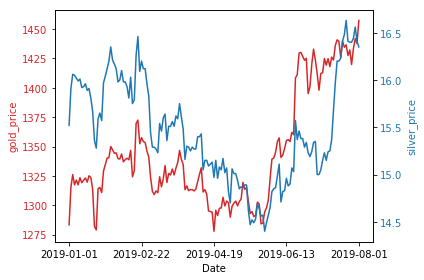

In [8]:
#plot the gold and silver price on the same graph


tick_spacing = 40

fig, ax1 = plt.subplots()


color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('gold_price', color=color)
ax1.plot(gold_silver_price['Date'],gold_silver_price['gold_price'], color=color)
ax1.tick_params(axis='y', labelcolor=color )
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('silver_price', color=color)   
ax2.plot( gold_silver_price['Date'],gold_silver_price['silver_price'], color=color)
ax2.tick_params(axis='y', labelcolor=color )
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

fig.tight_layout()   
plt.show()

 
The statistics of the commodities are calculated below.

In [9]:
gold_silver_price.mean()

gold_price      1344.858696
silver_price      15.455963
dtype: float64

In [10]:
gold_silver_price.median()

gold_price      1329.55
silver_price      15.37
dtype: float64

In [11]:
gold_silver_price.std()

gold_price      47.508002
silver_price     0.544552
dtype: float64

In [12]:
gold_silver_price.var()

gold_price      2257.010236
silver_price       0.296537
dtype: float64

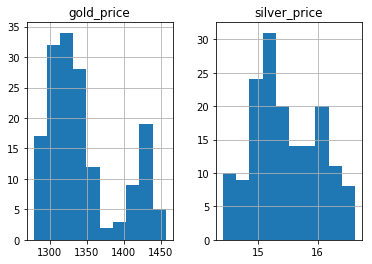

In [13]:

gold_silver_price.hist()
pyplot.show()
#The histogram of the gold and silver price

Time series are stationary if they do not have trend or seasonal effects. The mean and variance of the 
time series data are consistent over time if they are stationary.

Based on the observation of the plots, both of the silver and gold price are not stationary. But a 
statistical test is still needed to confirm my assumption.

I use two methods to check the stationary of commodity price. One is the rolling mean, another is the
Augmented Dickey-Fuller(ADF) test. 

First, I will draw the graph of the rolling mean and original data to check the stationarity.


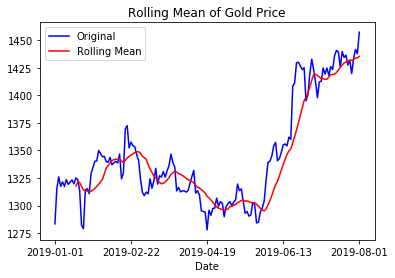

In [14]:
#calcualte the rolling mean and standard deviation of gold price
rolmean_gold = gold_silver_price['gold_price'].rolling(window=12).mean()
rolstd_gold = gold_silver_price['gold_price'].rolling(window=12).std()

#Plot rolling statistics:
fig, ax1 = plt.subplots()
ax1.plot( gold_silver_price['Date'],gold_silver_price['gold_price'], color='blue',label='Original')
ax1.plot( gold_silver_price['Date'],rolmean_gold, color='red', label='Rolling Mean')
#ax1.plot(rolstd_gold, color='black', label = 'Rolling Std')
ax1.set_xlabel('Date')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

plt.legend(loc='best')
plt.title('Rolling Mean of Gold Price')
plt.show(block=False)

The rolling mean is not a constant, so the gold price is not stationary.

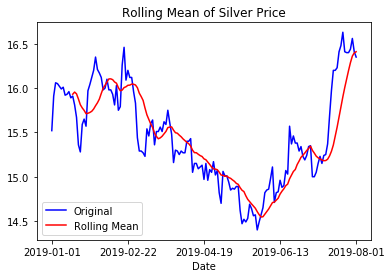

In [15]:
#calcualte the rolling mean and standard deviation of gold price
rolmean_silver = gold_silver_price['silver_price'].rolling(window=12).mean()
rolstd_silver = gold_silver_price['silver_price'].rolling(window=12).std()

#Plot rolling statistics:
fig, ax1 = plt.subplots()
ax1.plot( gold_silver_price['Date'],gold_silver_price['silver_price'], color='blue',label='Original')
ax1.plot( gold_silver_price['Date'],rolmean_silver, color='red', label='Rolling Mean')
#ax1.plot(rolstd_silver, color='black', label = 'Rolling Std')
ax1.set_xlabel('Date')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
 
plt.legend(loc='best')
plt.title('Rolling Mean of Silver Price')
plt.show(block=False)

The rolling mean is not a constant, so the silver price is not stationary.

In the next step, I use Augmented Dickey-Fuller(ADF) test to test the stationarity of the gold and silver price.

The null hypothesis of the ADF test is that the time series can be represented by a unit root, that it 
is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null
hypothesis) is that the time series is stationary.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning 
                      it is non-stationary. It has some time dependent structure.
        
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have 
                     a unit root, meaning it is stationary. It does not have time-dependent structure.
 


In [16]:

X_gold = gold_silver_price['gold_price'].values
result_gold = adfuller(X_gold) #calcualte the ADF test

In [17]:
print('ADF Statistic: %f' % result_gold[0])
print('p-value: %f' % result_gold[1])
print('Critical Values:')
for key, value in result_gold[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.807351
p-value: 0.816953
Critical Values:
	1%: -3.472
	5%: -2.880
	10%: -2.576


The p-value is 0.81>0.05, and the ADF Statistic = -0.81 > -2.5. So we cannot reject the null hypothesis. 
The gold price is not stationary. 

In [18]:
X_silver = gold_silver_price['silver_price'].values
result_silver = adfuller(X_silver) #calcualte the ADF test

In [19]:
print('ADF Statistic: %f' % result_silver[0])
print('p-value: %f' % result_silver[1])
print('Critical Values:')
for key, value in result_silver[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.443673
p-value: 0.561169
Critical Values:
	1%: -3.472
	5%: -2.880
	10%: -2.576


The p-value is 0.56>0.05, and the ADF Statistic = -1.44 > -2.5. So we cannot reject the null hypothesis. 
The silver price is not stationary.

Next, I will use ARIMA model to predict the gold and silver price.

ARIMA stands for Auto-Regressive Integrated Moving Averages. ARIMA model works on the following two 
assumptions.
1) The data series is stationary, which means the mean and variance of the data series are constant. 
A data series can transfer to stationary data series by using log transformation or differencing the series.
2) The data provided as input must be a univariate series, since ARIMA uses the past values to predict.

ARIMA model has three components: AR (autoregressive term), I (differencing term) and MA (moving average term).
These three components corresponds with the parameters (p,d,q).

1)AR term is the past values used to forecast the future value. The AR term is defined by the parameter 'p' in ARIMA. The parameter 'p' is determined using the PACF plot.

2)Order of differencing  specifies the number of transformations that applied on series to make it stationary.
Test like ADF can be used to determine whether the series is stationary and help in identifying the 'd' value.

3)MA term is past forecast errors used to predict the future values. The parameter 'q' in ARIMA represents
the MA term. ACF plot is used to identify the correct 'q' value.

Based on the assumption of ARIMA, I need to check the stationary of the gold and silver price before we apply 
the ARIMA model. As I have done before, both gold and silver is not stationary. I need to do some transformation before applying ARIMA. I define a function to test the stationary of the time series data. Then I take a two tranformations on the time series data to transfer the data into stationary, one is take a log of the data, second is make a difference between the time series data and the moving average.

In [20]:
#define a function to test the stationary of time series data;
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()

    #Plot rolling statistics:
    fig, ax1 = plt.subplots()
    ax1.plot( rolmean, color='blue',label='Original')
    ax1.plot( timeseries, color='red', label='Rolling Mean')
    #ax1.plot(rolstd_silver, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean ')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    result_test = adfuller(timeseries)
    print('ADF Statistic: %f' % result_test[0])
    print('p-value: %f' % result_test[1])
    print('Critical Values:')
    for key, value in result_test[4].items():
        print('\t%s: %.3f' % (key, value))

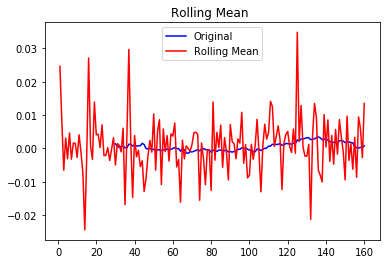

ADF Statistic: -13.072234
p-value: 0.000000
Critical Values:
	1%: -3.472
	5%: -2.880
	10%: -2.577


In [21]:

gold_price = gold_silver_price['gold_price'] 
gold_price_log = np.log(gold_price) #first transformation, take log

gold_price_log_diff = gold_price_log - gold_price_log.shift()

#moving_avg = gold_price_log.rolling(window=12).mean()
#gold_price_log_moving_avg_diff = gold_price_log - moving_avg #second transformation. differencing.
gold_price_log_diff.dropna(inplace=True)
test_stationarity(gold_price_log_diff)



The stationarity of the difference of the log of gold price is checked. it is stationary.Since only one difference is needed to arrive stationarity, d=1.

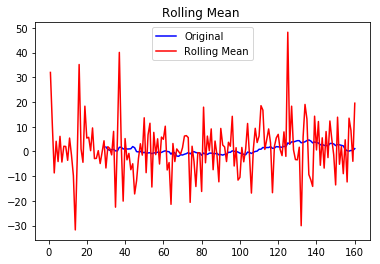

ADF Statistic: -13.071922
p-value: 0.000000
Critical Values:
	1%: -3.472
	5%: -2.880
	10%: -2.577


In [22]:
gold_price_diff = gold_price - gold_price.shift()

#moving_avg = gold_price_log.rolling(window=12).mean()
#gold_price_log_moving_avg_diff = gold_price_log - moving_avg #second transformation. differencing.
gold_price_diff.dropna(inplace=True)
test_stationarity(gold_price_diff)

The stationarity of the difference of gold price is checked, it is stationary.

In [23]:
def acf_pacf(timeseries):
    lag_acf = acf(timeseries, nlags=20)
    lag_pacf = pacf(timeseries, nlags=20, method='ols')
    #Plot ACF: 
    plt.subplot(121) 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')
    #Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()

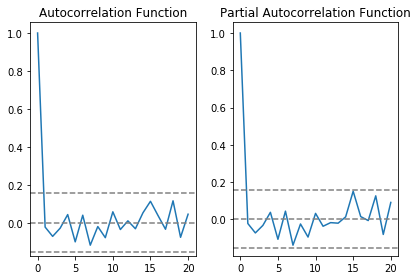

In [24]:
acf_pacf(gold_price_log_diff)


In this plot, the two dotted lines on either sides of 0 are the confidence intervals. These can be used to 
determine the p and q.

p: the lag value where the PACF chart crosses the upper confidence interval for the first time.In this case 
p is between 0 and 1.

q: the lag value where the ACF chart crosses the upper confidence interval for the first time.In this case 
q is between 0 and 1.

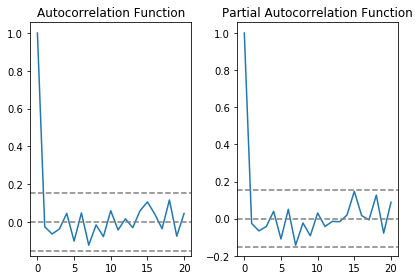

In [25]:
acf_pacf(gold_price_diff)

I will check the (p,d,q) in the range (0,1). Let's model the ARIMA(p,d,q) based on the parameters.
I use the SARIMA instead of ARIMA in python.


In [31]:
 warnings.filterwarnings("ignore")
def saic_sbic(p,q,timeseries):
    for x in range(0,p):
        for y in range(0,q):
            for m in range(0,p):
                for n in range(0,q):
                    try:
                        mod = sm.tsa.statespace.SARIMAX(timeseries.values,
                                        order=(x,1,y),
                                        seasonal_order=(m,1,n,12),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

                        results = mod.fit()

                        print('ARIMA{} - AIC:{}'.format(((x,1,y),(m,1,n,12)),  results.aic))
                        #print('ARIMA{} - BIC:{}'.format(((x,1,y),(m,1,n,12)),  results.bic))
                    except:
                        continue
            

In [32]:
 
def aic_bic(p,q,timeseries):
    for x in range(0,p):
        for y in range(0,q):
            try:
                mod = sm.tsa.statespace.SARIMAX(timeseries.values,
                                        order=(x,1,y),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

                results = mod.fit()

                print('ARIMA{} - AIC:{}'.format((x,1,y),  results.aic))
                #print('ARIMA{} - BIC:{}'.format((x,1,y),  results.bic))
            except:
                continue

In [33]:
saic_sbic(2,2,gold_price_log)

ARIMA((0, 1, 0), (0, 1, 0, 12)) - AIC:-898.134916899595
ARIMA((0, 1, 0), (0, 1, 1, 12)) - AIC:-890.2260419957133
ARIMA((0, 1, 0), (1, 1, 0, 12)) - AIC:-873.5798840324326
ARIMA((0, 1, 0), (1, 1, 1, 12)) - AIC:-878.1071687558829
ARIMA((0, 1, 1), (0, 1, 0, 12)) - AIC:-897.779798720369
ARIMA((0, 1, 1), (0, 1, 1, 12)) - AIC:-888.3921162291524
ARIMA((0, 1, 1), (1, 1, 0, 12)) - AIC:-871.5264380793149
ARIMA((0, 1, 1), (1, 1, 1, 12)) - AIC:-872.6723598477216
ARIMA((1, 1, 0), (0, 1, 0, 12)) - AIC:-896.1898806757465
ARIMA((1, 1, 0), (0, 1, 1, 12)) - AIC:-895.3197109326428
ARIMA((1, 1, 0), (1, 1, 0, 12)) - AIC:-865.0079867677485
ARIMA((1, 1, 0), (1, 1, 1, 12)) - AIC:-876.1067231568171
ARIMA((1, 1, 1), (0, 1, 0, 12)) - AIC:-896.9915139221328
ARIMA((1, 1, 1), (0, 1, 1, 12)) - AIC:-889.8441574502066
ARIMA((1, 1, 1), (1, 1, 0, 12)) - AIC:-862.5495017136485
ARIMA((1, 1, 1), (1, 1, 1, 12)) - AIC:-872.6548373339133


In [35]:
aic_bic(3,3,gold_price_log)

ARIMA(0, 1, 0) - AIC:-1081.1523748355744
ARIMA(0, 1, 1) - AIC:-1072.6081937186327
ARIMA(0, 1, 2) - AIC:-1063.8292847592224
ARIMA(1, 1, 0) - AIC:-1079.192925600073
ARIMA(1, 1, 1) - AIC:-1068.5198093887009
ARIMA(1, 1, 2) - AIC:-1061.9325712996983
ARIMA(2, 1, 0) - AIC:-1071.3059387541994
ARIMA(2, 1, 1) - AIC:-1068.6981689137688
ARIMA(2, 1, 2) - AIC:-1059.728983088806


The smallest AIC and BIC happens when (p,q,d)=(0,1,0). So we choose ARIMA(0,1,0).

In [36]:
mod_gold = sm.tsa.statespace.SARIMAX(gold_price_log.values,
                                        order=(0,1,0),
                                        #seasonal_order=(0,1,0,12),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  161
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 541.576
Date:                Sat, 17 Aug 2019   AIC                          -1081.152
Time:                        22:52:05   BIC                          -1078.083
Sample:                             0   HQIC                         -1079.906
                                - 161                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.441e-05   4.44e-06     14.520      0.000    5.57e-05    7.31e-05
Ljung-Box (Q):                       28.94   Jarque-Bera (JB):                73.69
Prob(Q):                              0.90   Pr

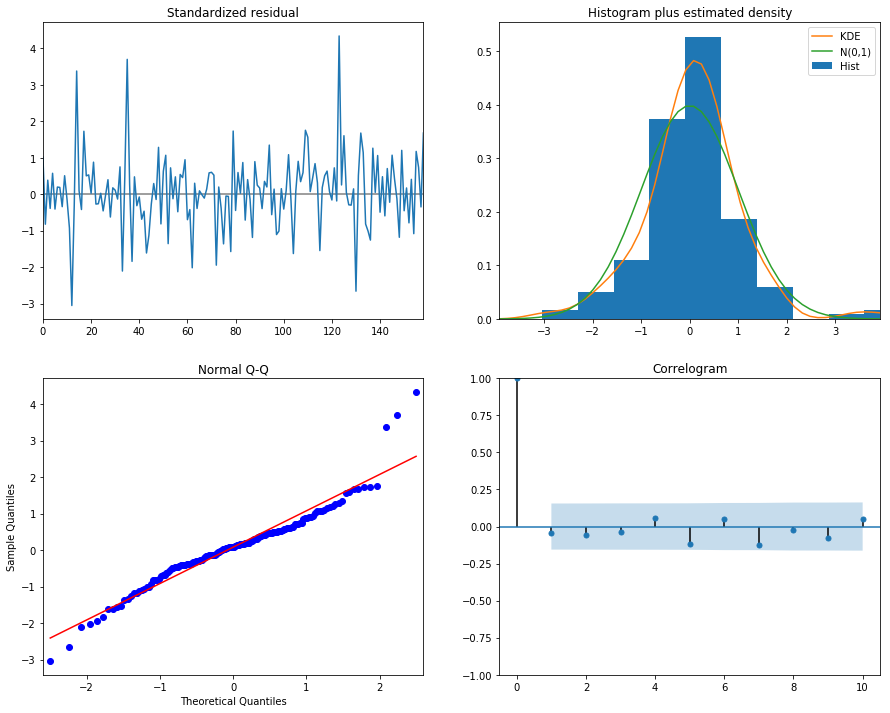

In [37]:
results = mod_gold.fit()
print(results.summary())
results.plot_diagnostics(figsize=(15, 12))
plt.show()

The diagnostic plots also show a good fit of the model.

In [38]:
#Let's use the ARIMA model to predict gold price.
#divide the price data into train and validation set
 
gold_train = gold_price_log[:int(0.7*(len(gold_price_log)))]
gold_train_diff = gold_price_log_diff[:int(0.7*(len(gold_price_log_diff)))]
gold_valid = gold_price_log[int(0.7*(len(gold_price_log))):]
gold_valid_diff = gold_price_log_diff[int(0.7*(len(gold_price_log_diff))):]

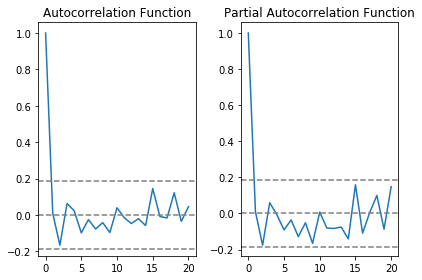

In [39]:
acf_pacf(gold_train_diff)

The acf and pacf plots shows that (p,d,q) is in the range (0,1). We check it in ARIMA model.

In [40]:
aic_bic(3,3,gold_train)
saic_sbic(3,3,gold_train)

ARIMA(0, 1, 0) - AIC:-757.6107484977883
ARIMA(0, 1, 1) - AIC:-749.1513938093224
ARIMA(0, 1, 2) - AIC:-743.4874071184403
ARIMA(1, 1, 0) - AIC:-755.638331281372
ARIMA(1, 1, 1) - AIC:-747.039814170115
ARIMA(1, 1, 2) - AIC:-741.3888317269435
ARIMA(2, 1, 0) - AIC:-751.2200605816424
ARIMA(2, 1, 1) - AIC:-749.5300128198771
ARIMA(2, 1, 2) - AIC:-739.5346969118027
ARIMA((0, 1, 0), (0, 1, 0, 12)) - AIC:-601.2216752046521
ARIMA((0, 1, 0), (0, 1, 1, 12)) - AIC:-578.1543991650395
ARIMA((0, 1, 0), (0, 1, 2, 12)) - AIC:-495.9605816741349
ARIMA((0, 1, 0), (1, 1, 0, 12)) - AIC:-560.8281156423645
ARIMA((0, 1, 0), (1, 1, 1, 12)) - AIC:-558.3978906158384
ARIMA((0, 1, 0), (1, 1, 2, 12)) - AIC:-484.750951509492
ARIMA((0, 1, 0), (2, 1, 0, 12)) - AIC:-500.1232604295296
ARIMA((0, 1, 0), (2, 1, 1, 12)) - AIC:-502.7894384222612
ARIMA((0, 1, 0), (2, 1, 2, 12)) - AIC:-496.2046674439773
ARIMA((0, 1, 1), (0, 1, 0, 12)) - AIC:-603.369236778946
ARIMA((0, 1, 1), (0, 1, 1, 12)) - AIC:-566.0266690255352
ARIMA((0, 1, 1), 

The ARIMA((2,1,0), (0,1,0,12) )is the fittest model based on the AIC and BIC value, while using training data.

In [47]:
model_train_gold = sm.tsa.statespace.SARIMAX(gold_train.values,
                                        order=(2,1,0),
                                        seasonal_order=(0,1,0,12),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
results_gold = model_train_gold.fit()
print(results_gold.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  112
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 304.977
Date:                            Sat, 17 Aug 2019   AIC                           -603.953
Time:                                    23:02:26   BIC                           -596.229
Sample:                                         0   HQIC                          -600.830
                                            - 112                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1336      0.140     -0.955      0.340      -0.408       0.141
ar.L2         -0.1718      0.083   

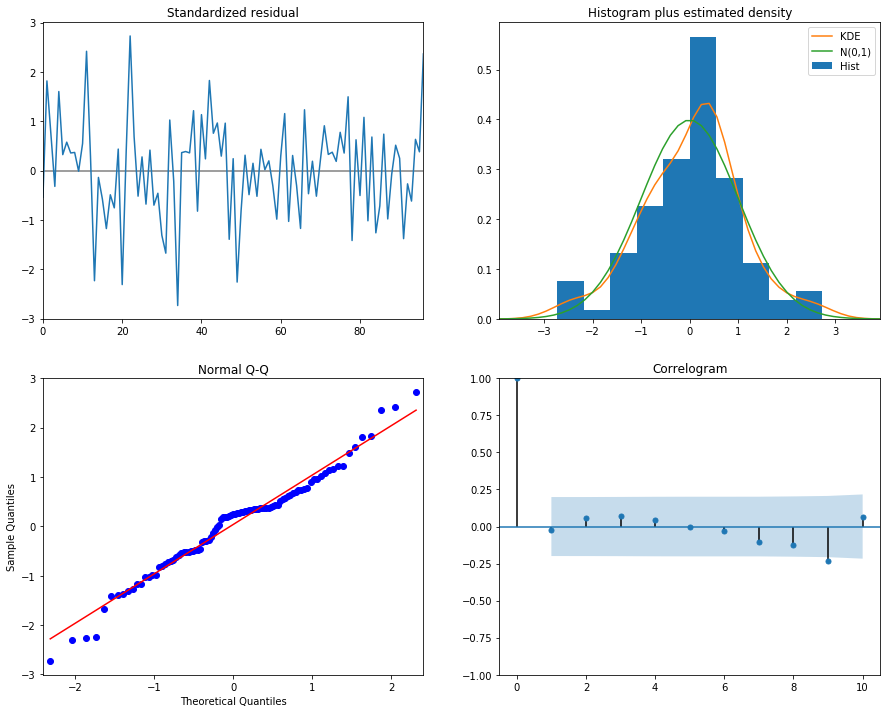

In [59]:
results_gold.plot_diagnostics(figsize=(15, 12))
plt.show()

In [48]:
gold_pred= results_gold.predict(start = len(gold_train)+1, end= len(gold_price), dynamic= True)
gold_pred = pd.DataFrame(gold_pred,index = gold_valid.index,columns=['Prediction'])
 

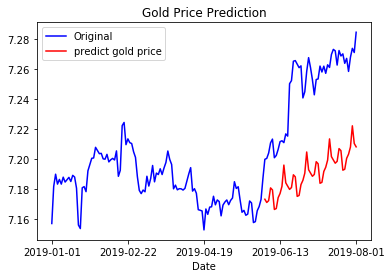

In [49]:
tick_spacing=40
fig, ax = plt.subplots()
#ax.plot(gold_train,color='black')
ax.plot(gold_silver_price['Date'],gold_price_log, color='blue',label='Original')
ax.plot( gold_pred, color='red', label='predict gold price')
#ax.plot( gold_pred1, color='yellow', label='predict gold price')
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

plt.legend(loc='best')
plt.title('Gold Price Prediction')
plt.show(block=False)
 

We can find that the model capturing the seasonal vibration very well, however, it cannot capture the suddenly jump in around 2019-06-13. I have tried ARIMA model with different parameters, all of them have similar problem. So I think that we need other information beyond the past price to explain this jump. 

In the next part, the ARIMA model will be used on silver price.

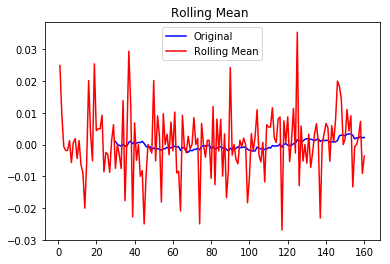

ADF Statistic: -13.536862
p-value: 0.000000
Critical Values:
	1%: -3.472
	5%: -2.880
	10%: -2.577


In [50]:
#Using the ARIMA model on silver price.
silver_price = gold_silver_price['silver_price'] 
silver_price_log = np.log(silver_price) #first transformation, take log

silver_price_log_diff = silver_price_log - silver_price_log.shift()

silver_price_log_diff.dropna(inplace=True)
test_stationarity(silver_price_log_diff)


The stationarity is arrived after one difference, so d=1. Let's check the p, q.

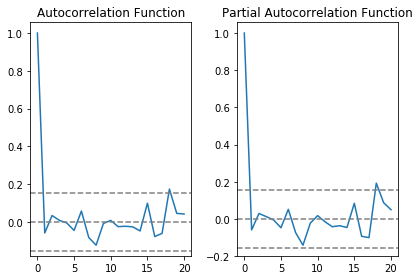

In [51]:
acf_pacf(silver_price_log_diff)

Based on acf and pacf graph, the (p,q) is in the range (0,1). Let's model the ARIMA(p,1,q) in the range(0,1).
 

In [52]:
#Let's use the ARIMA model to predict gold price.
#divide the price data into train and validation set
 
silver_train = silver_price_log[:int(0.7*(len(silver_price_log)))]
silver_train_diff = silver_price_log_diff[:int(0.7*(len(silver_price_log_diff)))]
silver_valid = silver_price_log[int(0.7*(len(silver_price_log))):]
silver_valid_diff = silver_price_log_diff[int(0.7*(len(silver_price_log_diff))):]

In [53]:
saic_sbic(3,3,silver_train)

ARIMA((0, 1, 0), (0, 1, 0, 12)) - AIC:-556.3255223433529
ARIMA((0, 1, 0), (0, 1, 1, 12)) - AIC:-532.8502454284244
ARIMA((0, 1, 0), (0, 1, 2, 12)) - AIC:-452.5611922297176
ARIMA((0, 1, 0), (1, 1, 0, 12)) - AIC:-513.849288197252
ARIMA((0, 1, 0), (1, 1, 1, 12)) - AIC:-513.264873698338
ARIMA((0, 1, 0), (1, 1, 2, 12)) - AIC:-452.01244547692477
ARIMA((0, 1, 0), (2, 1, 0, 12)) - AIC:-450.4434684417366
ARIMA((0, 1, 0), (2, 1, 1, 12)) - AIC:-455.2853760498036
ARIMA((0, 1, 0), (2, 1, 2, 12)) - AIC:-450.0080282631576
ARIMA((0, 1, 1), (0, 1, 0, 12)) - AIC:-552.9575449594123
ARIMA((0, 1, 1), (0, 1, 1, 12)) - AIC:-521.7803177611302
ARIMA((0, 1, 1), (0, 1, 2, 12)) - AIC:-448.5668168287023
ARIMA((0, 1, 1), (1, 1, 0, 12)) - AIC:-510.83335493130085
ARIMA((0, 1, 1), (1, 1, 1, 12)) - AIC:-506.09400332526275
ARIMA((0, 1, 1), (1, 1, 2, 12)) - AIC:-448.39372904310596
ARIMA((0, 1, 1), (2, 1, 0, 12)) - AIC:-450.5054235947561
ARIMA((0, 1, 1), (2, 1, 1, 12)) - AIC:-458.40885468765856
ARIMA((0, 1, 1), (2, 1, 2, 1

The smallest AIC and BIC happens when (p,d,q)=(0,1,0), (p,d,q,s)=(0,1,0,12). So we choose ARIMA((0,1,0)(0,1,0,12)).

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  112
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 279.163
Date:                            Sat, 17 Aug 2019   AIC                           -556.326
Time:                                    23:24:17   BIC                           -553.741
Sample:                                         0   HQIC                          -555.280
                                            - 112                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0002   2.98e-05      6.578      0.000       0.000       0.000
Ljung-Box (Q):                     

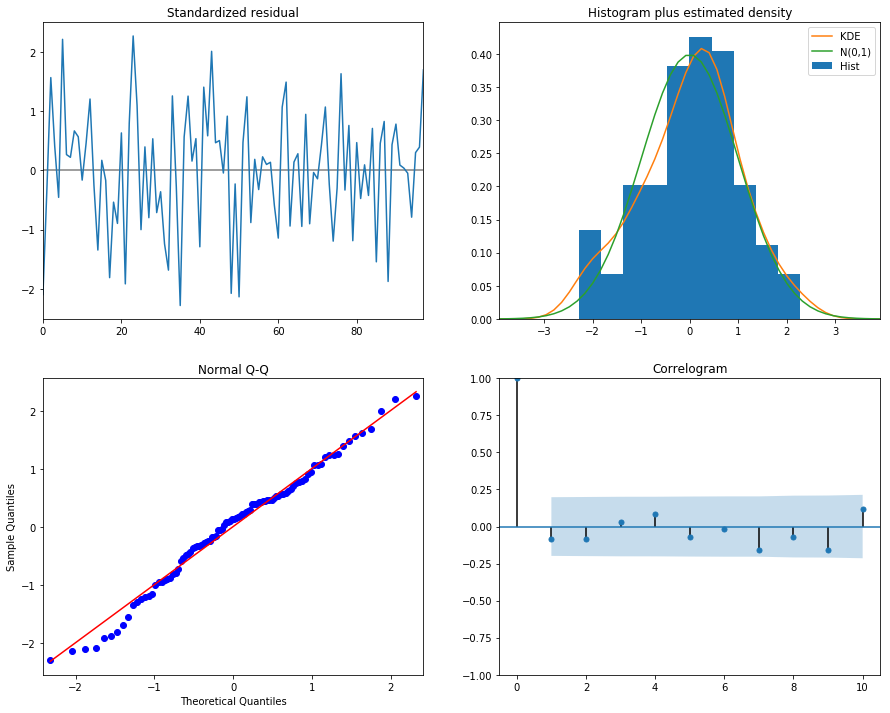

In [65]:
model_silver = sm.tsa.statespace.SARIMAX(silver_train.values,
                                        order=(0,1,0),
                                        seasonal_order=(0,1,0,12),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
results_silver = model_silver.fit()
print(results_silver.summary())
results_silver.plot_diagnostics(figsize=(15, 12))
plt.show()
silver_pred= results_silver.predict(start = len(silver_train)+1, end= len(silver_price), dynamic= True)
silver_pred = pd.DataFrame(silver_pred,index = silver_valid.index,columns=['Prediction']) 

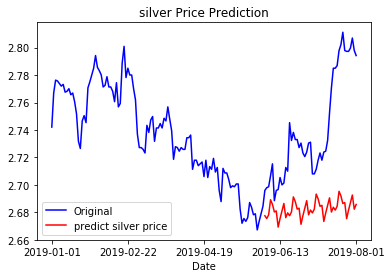

In [56]:
tick_spacing=40
fig, ax = plt.subplots()
#ax.plot(gold_train,color='black')
ax.plot(gold_silver_price['Date'],silver_price_log, color='blue',label='Original')
ax.plot( silver_pred, color='red', label='predict silver price')
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

plt.legend(loc='best')
plt.title('silver Price Prediction')
plt.show(block=False)

The result for the silver price is similar to gold price. The model capturing the seasonal vibration very well, however, it cannot capture the suddenly jump. I have tried ARIMA model with different parameters, all of them have similar problem. So I think that we need other information beyond the past price to explain this jump. We also see a good forecast for the most recent period. So using the most recent price data to predict the commodity price can give us a better prediction.

Next step, I will use logistic regression model to determine if past prices are useful in predicting the direction of change (increase or decrease). 
 


In [66]:
gold_silver_price.head()

,Date,gold_price,silver_price
0,2019-01-01,1283.35,15.52
1,2019-01-02,1315.30,15.91
2,2019-01-03,1326.10,16.06
3,2019-01-04,1317.40,16.05
4,2019-01-07,1321.50,16.02


In [67]:
col = ['Date','gold_price']
gold_X_y = gold_silver_price[col]
gold_X_y.head()

,Date,gold_price
0,2019-01-01,1283.35
1,2019-01-02,1315.30
2,2019-01-03,1326.10
3,2019-01-04,1317.40
4,2019-01-07,1321.50


First, I create columns that represent the change direction of gold and silver price.

In [70]:
gold_X_y['gold_change_dir']=np.nan
gold_X_y['gold_price_diff'] = gold_price - gold_price.shift()
for x in range(1,len(gold_X_y)):
    if gold_X_y.loc[x,'gold_price_diff'] >= 0:
        gold_X_y.loc[x,'gold_change_dir'] = 1
    else:
        gold_X_y.loc[x,'gold_change_dir'] = 0

 

In [71]:
#price difference is created.
gold_X_y['gold_price_diff_shift1'] = (gold_price - gold_price.shift()).shift()
gold_X_y['gold_price_diff_shift2'] = (gold_price - gold_price.shift().shift()).shift()
gold_X_y['gold_price_diff_shift3'] = (gold_price - gold_price.shift().shift().shift()).shift()
gold_X_y['gold_price_diff_shift4'] = (gold_price - gold_price.shift().shift().shift().shift()).shift()


In [72]:
#log of the price
gold_X_y['gold_price_log'] = gold_X_y['gold_price'].apply(lambda x: np.log(x))

In [73]:
#rolling mean of the price
gold_X_y['gold_rolmean1'] = gold_X_y['gold_price_log'].rolling(window=1).mean().shift()
gold_X_y['gold_rolmean2'] = gold_X_y['gold_price_log'].rolling(window=2).mean().shift()
gold_X_y['gold_rolmean3'] = gold_X_y['gold_price_log'].rolling(window=3).mean().shift()
gold_X_y['gold_rolmean4'] = gold_X_y['gold_price_log'].rolling(window=4).mean().shift()
gold_X_y['gold_rolmean5'] = gold_X_y['gold_price_log'].rolling(window=5).mean().shift()
gold_X_y['gold_rolmean6'] = gold_X_y['gold_price_log'].rolling(window=6).mean().shift()

In [74]:
gold_X_y.head()

,Date,gold_price,gold_change_dir,gold_price_diff,gold_price_diff_shift1,gold_price_diff_shift2,gold_price_diff_shift3,gold_price_diff_shift4,gold_price_log,gold_rolmean1,gold_rolmean2,gold_rolmean3,gold_rolmean4,gold_rolmean5,gold_rolmean6
0,2019-01-01,1283.35,NaN,NaN,NaN,NaN,NaN,NaN,7.157229,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-02,1315.30,1.0,31.95,NaN,NaN,NaN,NaN,7.181820,7.157229,NaN,NaN,NaN,NaN,NaN
2,2019-01-03,1326.10,1.0,10.80,31.95,NaN,NaN,NaN,7.189998,7.181820,7.169525,NaN,NaN,NaN,NaN
3,2019-01-04,1317.40,0.0,-8.70,10.80,42.75,NaN,NaN,7.183415,7.189998,7.185909,7.176349,NaN,NaN,NaN
4,2019-01-07,1321.50,1.0,4.10,-8.70,2.10,34.05,NaN,7.186523,7.183415,7.186706,7.185078,7.178116,NaN,NaN


In [75]:
gold_X_y.dropna(inplace=True)

In [76]:
gold_X_y.head()

,Date,gold_price,gold_change_dir,gold_price_diff,gold_price_diff_shift1,gold_price_diff_shift2,gold_price_diff_shift3,gold_price_diff_shift4,gold_price_log,gold_rolmean1,gold_rolmean2,gold_rolmean3,gold_rolmean4,gold_rolmean5,gold_rolmean6
6,2019-01-09,1323.5,1.0,6.1,-4.1,0.0,-8.7,2.1,7.188035,7.183415,7.184969,7.184451,7.185838,7.185034,7.180400
7,2019-01-10,1319.2,0.0,-4.3,6.1,2.0,6.1,-2.6,7.184781,7.188035,7.185725,7.185991,7.185347,7.186277,7.185534
8,2019-01-11,1321.3,1.0,2.1,-4.3,1.8,-2.3,1.8,7.186371,7.184781,7.186408,7.185410,7.185688,7.185234,7.186028
9,2019-01-14,1323.3,1.0,2.0,2.1,-2.2,3.9,-0.2,7.187884,7.186371,7.185576,7.186396,7.185651,7.185825,7.185423
10,2019-01-15,1319.7,0.0,-3.6,2.0,4.1,-0.2,5.9,7.185160,7.187884,7.187128,7.186345,7.186768,7.186097,7.186168


In [77]:
#gold_features_col = ['gold_price_diff_shift1','gold_price_diff_shift2','gold_price_diff_shift3', 'gold_rolmean1','gold_rolmean2','gold_rolmean3']

gold_features_col = [ 'gold_price_diff_shift1', 'gold_rolmean1']
X = gold_X_y[gold_features_col]
y = gold_X_y['gold_change_dir']

In [78]:
X.head()

,gold_price_diff_shift1,gold_rolmean1
6,-4.1,7.183415
7,6.1,7.188035
8,-4.3,7.184781
9,2.1,7.186371
10,2.0,7.187884


In [79]:
y.head()

6     1.0
7     0.0
8     1.0
9     1.0
10    0.0
Name: gold_change_dir, dtype: float64

In [80]:
from sklearn.model_selection import train_test_split
 
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [81]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
clf_A = AdaBoostClassifier(random_state = 5)
clf_B = SGDClassifier(random_state=7)
clf_C = DecisionTreeClassifier(random_state=0)
clf_D = LogisticRegression() 
# fit the model with data
clf_A.fit(X_train,y_train)
clf_B.fit(X_train,y_train)
clf_C.fit(X_train,y_train)
clf_D.fit(X_train,y_train)
#make the prediction
y_pred_A=clf_A.predict(X_test)
y_pred_B=clf_B.predict(X_test)
y_pred_C=clf_C.predict(X_test)
y_pred_D=clf_D.predict(X_test)

In [82]:
print('Accuracy of AdaBoost classifier on test set: {:.2f}'.format(clf_A.score(X_test, y_test)))
print('Accuracy of SGD classifier on test set: {:.2f}'.format(clf_B.score(X_test, y_test)))
print('Accuracy of DecisionTree regression classifier on test set: {:.2f}'.format(clf_C.score(X_test, y_test)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(clf_D.score(X_test, y_test)))

Accuracy of AdaBoost classifier on test set: 0.58
Accuracy of SGD classifier on test set: 0.45
Accuracy of DecisionTree regression classifier on test set: 0.45
Accuracy of logistic regression classifier on test set: 0.55


So accuracy of a classification model is around 50%. I have tried different features that construced by the past price, the result is similar.

In [83]:
col = ['Date', 'silver_price']
silver_X_y = gold_silver_price[col]
silver_X_y.head()

,Date,silver_price
0,2019-01-01,15.52
1,2019-01-02,15.91
2,2019-01-03,16.06
3,2019-01-04,16.05
4,2019-01-07,16.02


In [84]:
silver_X_y['silver_change_dir'] = np.nan
silver_X_y['silver_price_diff'] = silver_price - silver_price.shift()
for x in range(1,len(silver_X_y)):
    if silver_X_y.loc[x,'silver_price_diff'] >= 0:
        silver_X_y.loc[x,'silver_change_dir'] = 1
    else:
        silver_X_y.loc[x,'silver_change_dir'] = 0

In [85]:
silver_X_y['silver_price_diff_shift1'] = (silver_price - silver_price.shift()).shift()
silver_X_y['silver_price_diff_shift2'] = (silver_price - silver_price.shift().shift()).shift()
silver_X_y['silver_price_diff_shift3'] = (silver_price - silver_price.shift().shift().shift()).shift()
silver_X_y['silver_price_diff_shift4'] = (silver_price - silver_price.shift().shift().shift().shift()).shift()

silver_X_y['silver_price_log'] = silver_X_y['silver_price'].apply(lambda x: np.log(x))

silver_X_y['silver_rolmean1'] = silver_X_y['silver_price_log'].rolling(window=1).mean().shift()
silver_X_y['silver_rolmean2'] = silver_X_y['silver_price_log'].rolling(window=2).mean().shift()
silver_X_y['silver_rolmean3'] = silver_X_y['silver_price_log'].rolling(window=3).mean().shift()
silver_X_y['silver_rolmean4'] = silver_X_y['silver_price_log'].rolling(window=4).mean().shift()
silver_X_y['silver_rolmean5'] = silver_X_y['silver_price_log'].rolling(window=5).mean().shift()
silver_X_y['silver_rolmean6'] = silver_X_y['silver_price_log'].rolling(window=6).mean().shift()

silver_X_y.dropna(inplace=True)


#silver_features_col = ['silver_price_diff_shift1','silver_price_diff_shift2','silver_price_diff_shift3', 'silver_rolmean1','silver_rolmean2','silver_rolmean3']

silver_features_col = [ 'silver_price_diff_shift1', 'silver_rolmean1']
X = silver_X_y[silver_features_col]
y = silver_X_y['silver_change_dir']


In [86]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [122]:
from sklearn.ensemble import RandomForestRegressor
def classif(X_train,X_test,y_train,y_test):
    # instantiate the model (using the default parameters)
    clf_A = AdaBoostClassifier(random_state = 5)
    clf_B = SGDClassifier(random_state=7)
    clf_C = DecisionTreeClassifier(random_state=0)
    clf_D = LogisticRegression() 
    #clf_A = RandomForestRegressor(n_estimators=10, random_state=2)
     # fit the model with data
    clf_A.fit(X_train,y_train)
    clf_B.fit(X_train,y_train)
    clf_C.fit(X_train,y_train)
    clf_D.fit(X_train,y_train)
    #clf_E.fit(X_train,y_train)
    #make the prediction
    y_pred_A=clf_A.predict(X_test)
    y_pred_B=clf_B.predict(X_test)
    y_pred_C=clf_C.predict(X_test)
    y_pred_D=clf_D.predict(X_test)
    #y_pred_E=clf_E.predict(X_test)
    return (clf_A,clf_B,clf_C,clf_D)

classif(X_train,X_test,y_train,y_test)

(AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
           learning_rate=1.0, n_estimators=50, random_state=5),
 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
        early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
        l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
        n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
        power_t=0.5, random_state=7, shuffle=True, tol=None,
        validation_fraction=0.1, verbose=0, warm_start=False),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_i

In [121]:
print('Accuracy of AdaBoost classifier on test set: {:.2f}'.format(clf_A.score(X_test, y_test)))
print('Accuracy of SGD classifier on test set: {:.2f}'.format(clf_B.score(X_test, y_test)))
print('Accuracy of DecisionTree regression classifier on test set: {:.2f}'.format(clf_C.score(X_test, y_test)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(clf_D.score(X_test, y_test)))
#print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(clf_E.score(X_test, y_test)))

Accuracy of AdaBoost classifier on test set: 0.48
Accuracy of SGD classifier on test set: 0.55
Accuracy of DecisionTree regression classifier on test set: 0.55
Accuracy of logistic regression classifier on test set: 0.45


The accuracy of the classification is around 50%. I can conclude that using the previous price cannot predict the change direction of the commodity price.